In [42]:
from utils import load_data
import pandas as pd
import numpy as np
from scipy import sparse
import implicit
from sklearn.model_selection import train_test_split
from implicit import evaluation
import matplotlib.pyplot as plt

In [43]:
df = load_data("./active1000")
df["time"] = df["time"].apply(
    lambda date: pd.Timestamp(date, unit="s", tz="Europe/Oslo")
)
df.drop(index=df[df.url == "http://adressa.no"].index, inplace=True)


In [44]:
def dataframe_to_user_item_matrix(df):
    df = df.drop_duplicates(subset=['userId', 'documentId'])
    df = df.sort_values(by=['userId', 'time'])

    n_users = df['userId'].nunique()
    n_items = df['documentId'].count()

    ratings = np.zeros((n_users, n_items))

    new_user = df['userId'].values[1:] != df['userId'].values[:-1]
    new_user = np.r_[True, new_user]

    df['uid'] = np.cumsum(new_user)
    item_ids = df['documentId'].unique().tolist()

    new_df = pd.DataFrame({'documentId': item_ids, 'tid': range(1, len(item_ids) + 1)})

    df = pd.merge(df, new_df, on='documentId', how='outer')
    user_id_document_df = df[['documentId', 'uid', 'userId']]
    df_ext = df[['uid', 'tid']]

    users_df = df["uid"].unique()
    user_indexes = set()

    for row in df_ext.itertuples():
        ratings[row[1] - 1, row[2] - 1] = 1.0

        if row[1] in users_df:
            user_indexes.add(row[1] - 1)

    print(f"Matrix created with {ratings.shape[0]} users and {ratings.shape[1]} items")
    return ratings, user_indexes, item_ids, user_id_document_df

user_item_data, user_indexes, item_ids, user_id_document_df = dataframe_to_user_item_matrix(df)

user_item_sparse_matrix = sparse.csr_matrix(user_item_data)
train_data, test_data = train_test_split(user_item_sparse_matrix, random_state=23, test_size=0.25)

Matrix created with 1000 users and 679355 items


In [45]:
model = implicit.als.AlternatingLeastSquares(factors=50)
model.fit(train_data)

100%|██████████| 15/15 [00:04<00:00,  3.09it/s]


In [46]:
recommendations = model.recommend(0, test_data[0], filter_already_liked_items=True, recalculate_user=True, N=50)
ids = list(map(lambda x: item_ids[x], list(recommendations[0])))
print(list(zip(ids, list(recommendations[1]))))

[('aa6a5862cb2ae9fb8996f35a692192559b9083e1', 0.808554), ('0a8c6555c75b8fd530be97356c8b62f6a6a4ad83', 0.782723), ('0bad5f842d38601fe714f625d46be941fb27f28c', 0.6679427), ('1ae48cc9bf00e7a94c6fb70e7beb74ee9b926998', 0.665044), ('50c3b54c898d2c76681b4e4c02bad53b7a26b01b', 0.65843374), ('cd625da5a4f18ba4912ce7c6a50340b364c2c7f1', 0.63767695), ('01e4d502d724e6206166c33c0ad50a456282124f', 0.63278866), ('7b37701ba1916986c0d63c074df278f9ea9117cb', 0.6207638), ('2febaa0c1a2bb66a3dda745c33ba3da7cc81a55b', 0.5882487), ('e9a8deeda6a04df6afb887619a3a1880250aed7a', 0.5858353), ('60a5adfd53e73e44d1fdd9ed07c890879640b2e6', 0.5720585), ('1e78b84f637a2032210f638c1e0242821f6d2510', 0.5717564), ('b85abfb0937cf948a48ca22758a4e03407bc3fcc', 0.5675347), ('92cf23b4733e4ce19f012cbf2a0db25b0a7dd02f', 0.5647539), ('b9ad78ebb5acf15b97a2172aae104903e2a41afe', 0.5618984), ('dd5cc5ad8c5152fb52600d741fc0f6174a93c8bb', 0.5609788), ('2ba425ed450c17c98bb10837f6ab902dd3e4df6d', 0.5603115), ('a4108a6448e235d895c62807f493

In [47]:

def evaluate_recall(ids, user_index):
    user_id = user_id_document_df[user_id_document_df.uid == user_index].iloc[0]['userId']
    true_positive = 0
    total = 0
    current_df = user_id_document_df.drop_duplicates(subset=['documentId', 'userId'])
    mask = current_df.userId.apply(lambda x: x == user_id)
    current_df = current_df[mask]

    docs_recommended_properly = []
    docs_not_recommended_properly = []

    for id in ids:
        try:
            if current_df[current_df.documentId == id].documentId.values[0] == id:
                docs_recommended_properly.append(id)
                true_positive += 1
        except:
            docs_not_recommended_properly.append(id)
        total += 1
    false_negative = current_df.count().uid - true_positive
    #print("Recall: " + str(true_positive / (true_positive + false_negative)) + "\n")
    #print("True positives: " + str(docs_recommended_properly))
    #print("False positives: " + str(docs_not_recommended_properly))
    return true_positive / (true_positive + false_negative)
evaluate_recall(ids, 1)
    

0.019138755980861243

In [48]:
evaluation.mean_average_precision_at_k(model, train_data, test_data)

100%|██████████| 250/250 [00:00<00:00, 571.52it/s]


0.2921287301587302

In [53]:
'''
Testing for different recall values on different users with recommendations set to 50
'''
recalls = []
for y in range(0, 100):
    recommendations = model.recommend(y, test_data[y], filter_already_liked_items=True, recalculate_user=True, N=50)
    ids = list(map(lambda x: item_ids[x], list(recommendations[0])))
    recalls.append(evaluate_recall(ids, y+1))
print('recalls: ' + str(recalls) + '\n')
print('average recall: ' + str(sum(recalls) / len(recalls)))


recalls: [0.019138755980861243, 0.04263565891472868, 0.03535353535353535, 0.03543307086614173, 0.026888604353393086, 0.03795620437956204, 0.029227557411273485, 0.0070921985815602835, 0.03716814159292035, 0.0325, 0.07651715039577836, 0.022727272727272728, 0.02591283863368669, 0.04072398190045249, 0.025, 0.05543237250554324, 0.031189083820662766, 0.031496062992125984, 0.024691358024691357, 0.03474903474903475, 0.04296875, 0.024267782426778243, 0.026988636363636364, 0.02491103202846975, 0.017142857142857144, 0.034482758620689655, 0.03177966101694915, 0.018947368421052633, 0.0391566265060241, 0.03773584905660377, 0.04895104895104895, 0.014925373134328358, 0.023121387283236993, 0.019629225736095966, 0.0165016501650165, 0.0313588850174216, 0.013126491646778043, 0.03654080389768575, 0.02531645569620253, 0.03518518518518519, 0.027600849256900213, 0.03865979381443299, 0.039705882352941174, 0.029914529914529916, 0.034623217922606926, 0.05116279069767442, 0.019642857142857142, 0.02488687782805429

<BarContainer object of 100 artists>

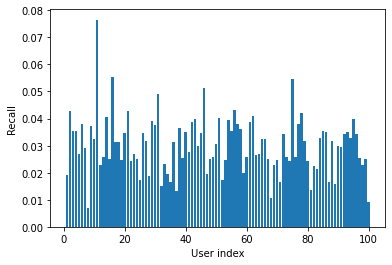

In [54]:
plt.ylabel('Recall')
plt.xlabel('User index')
plt.bar([x for x in range(1, 101)], height=recalls, data=recalls)

In [51]:
'''
Testing for different recall values on different recommendations for the same user
'''
recalls = []
for x in range(1, 101):
    recommendations = model.recommend(0, test_data[0], filter_already_liked_items=True, recalculate_user=True, N=x)
    ids = list(map(lambda x: item_ids[x], list(recommendations[0])))
    recalls.append(evaluate_recall(ids, 1))
print('recalls: ' + str(recalls) + '\n')
print('average recall: ' + str(sum(recalls) / len(recalls)))


recalls: [0.001594896331738437, 0.001594896331738437, 0.001594896331738437, 0.001594896331738437, 0.001594896331738437, 0.003189792663476874, 0.003189792663476874, 0.003189792663476874, 0.004784688995215311, 0.006379585326953748, 0.007974481658692184, 0.007974481658692184, 0.009569377990430622, 0.009569377990430622, 0.009569377990430622, 0.009569377990430622, 0.009569377990430622, 0.009569377990430622, 0.009569377990430622, 0.009569377990430622, 0.009569377990430622, 0.009569377990430622, 0.011164274322169059, 0.012759170653907496, 0.014354066985645933, 0.01594896331738437, 0.01594896331738437, 0.01594896331738437, 0.01594896331738437, 0.01594896331738437, 0.017543859649122806, 0.019138755980861243, 0.019138755980861243, 0.019138755980861243, 0.019138755980861243, 0.019138755980861243, 0.019138755980861243, 0.019138755980861243, 0.019138755980861243, 0.019138755980861243, 0.019138755980861243, 0.019138755980861243, 0.019138755980861243, 0.019138755980861243, 0.019138755980861243, 0.019

<BarContainer object of 100 artists>

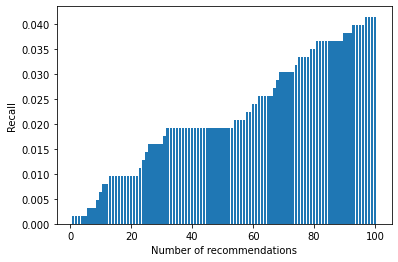

In [52]:
plt.ylabel('Recall')
plt.xlabel('Number of recommendations')
plt.bar([x for x in range(1, 101)], height=recalls, data=recalls)